In [1]:

import numpy as np
import tensorflow as tf

%pylab inline

import mccd
from astropy.io import fits
from mccd.denoising.learnlets.learnlet_model import Learnlet


Populating the interactive namespace from numpy and matplotlib


## Check out the learnlet proximal operator definition


In [3]:

old_weights_path = '/Users/tliaudat/Documents/PhD/github/cosmostat_official/deep_mccd/results/trained_networks/old_learnlet_model/cp.h5'
new_weights_path = '/Users/tliaudat/Documents/PhD/github/cosmostat_official/deep_mccd/results/trained_networks/learnlets_256/cp_256.h5'


In [6]:
# Old learnlets

im_shape = (51,51)

im_val = tf.convert_to_tensor(np.random.rand(2, im_shape[0], im_shape[1], 1))
std_val = tf.convert_to_tensor(np.random.rand(2))
run_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 256,
        'mixing_details': False,
        'skip_connection': True,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
    },
    'threshold_kwargs':{
        'noise_std_norm': True,
    },
#     'wav_type': 'bior',
    'n_scales': 5,
    'n_reweights_learn': 1,
    'clip': False,
}

learnlets = Learnlet(**run_params)
learnlets.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-3),
    loss='mse',
)
learnlets.fit(
    (im_val, std_val),
    im_val,
    validation_data = ((im_val, std_val), im_val),
    steps_per_epoch = 1,
    epochs = 1,
    batch_size=12,
)
learnlets.load_weights(old_weights_path)
old_model = learnlets




1/1 [==============================] - 2s 2s/step - loss: 0.1119 - val_loss: 0.0990


In [7]:
# New learnlets

new_learnlets = Learnlet(**run_params)
new_learnlets.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-3),
    loss='mse',
)
new_learnlets.fit(
    (im_val, std_val),
    im_val,
    validation_data = ((im_val, std_val), im_val),
    steps_per_epoch = 1,
    epochs = 1,
    batch_size=12,
)
new_learnlets.load_weights(new_weights_path)
new_model = new_learnlets



1/1 [==============================] - 2s 2s/step - loss: 0.1120 - val_loss: 0.1133


### Generate noisy dataset

In [148]:
def np_normalise(image):
    """ Normalise. 
    
    I in [a,b]
    Operations are:
    [0,b-a]
    [0, 1]
    tilde(I) in [-0.5, 0.5]
    """

    image -= np.min(image)
    image /= np.max(image)
    return image - 0.5


In [15]:

global_eigenPSF_path = '/Users/tliaudat/Documents/PhD/github/cosmostat_official/deep_mccd/results/aziz_results/eigenPSF_datasets/global_eigenpsfs.fits'

glob_eigen = fits.open(global_eigenPSF_path)

glob_eigen[1].columns

ColDefs(
    name = 'VIGNETS_NOISELESS'; format = '2601D'; dim = '(51, 51)'
)

In [158]:
# norms = np.array([np.sqrt(np.sum(im**2)) for im in eigenPSFs])

norm_eigen = np.array([im/np.sqrt(np.sum(im**2)) for im in eigenPSFs])




In [160]:
# sums =  np.array([np.sum(abs(im)) for im in eigenPSFs])

norm_1_eigen = np.array([im/np.sum(abs(im)) for im in eigenPSFs])


In [163]:

# val_norm = np.array([np.sum(abs(np_normalise(im))) for im in eigenPSFs])

scaled_eigen = np.array([np_normalise(im) for im in eigenPSFs])


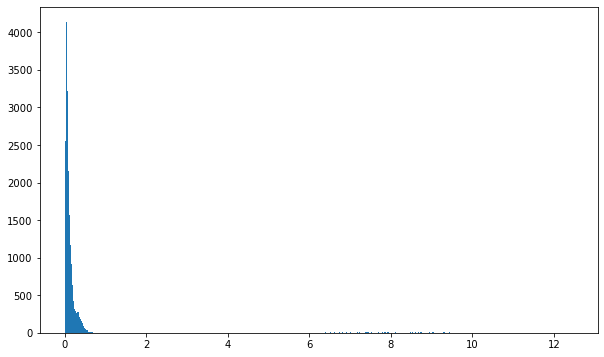

In [168]:

figure(figsize=(10,6))
_ = plt.hist(norms, bins=500)#, range=[0,1])




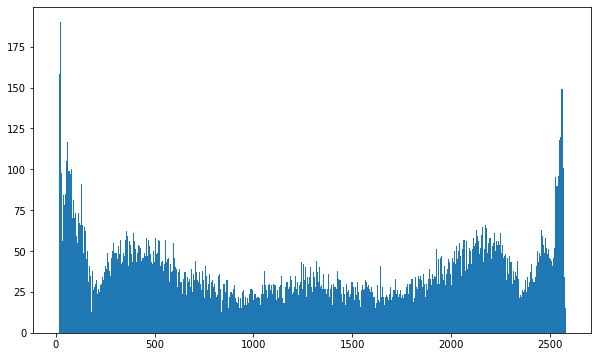

In [152]:
figure(figsize=(10,6))
_ = plt.hist(sums, bins=500)#, range=[0,1])


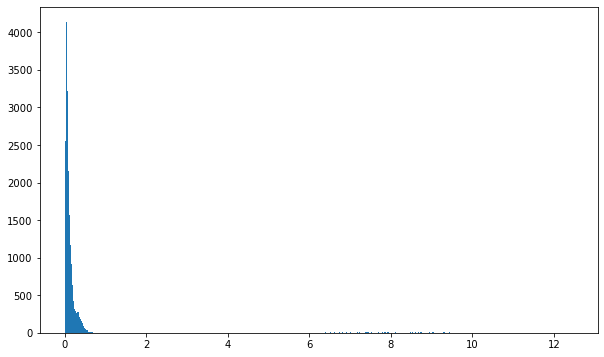

In [137]:

figure(figsize=(10,6))
_ = plt.hist(norms, bins=500)#, range=[0,1])


In [138]:
# Check out items with sums > 6

sum_mask = sums > 6
masked_eigen = eigenPSFs[sum_mask]


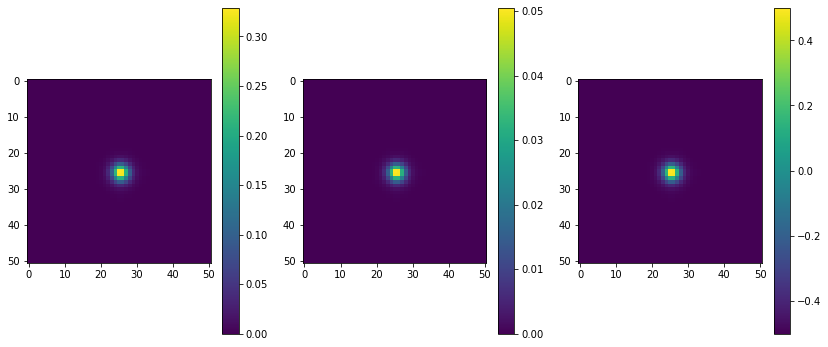

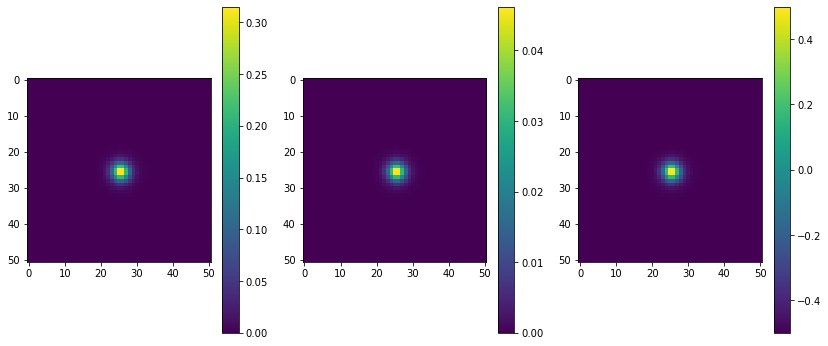

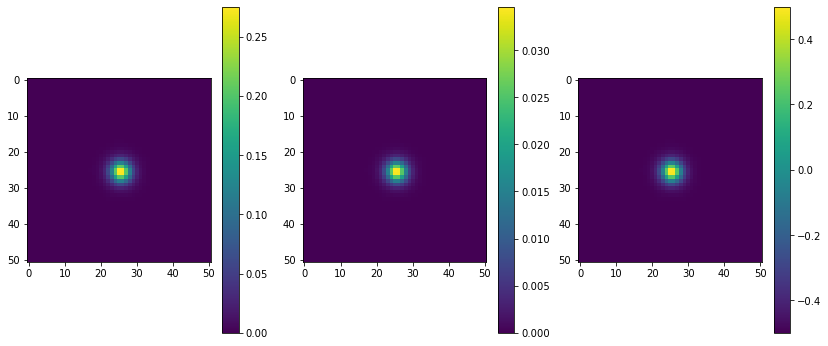

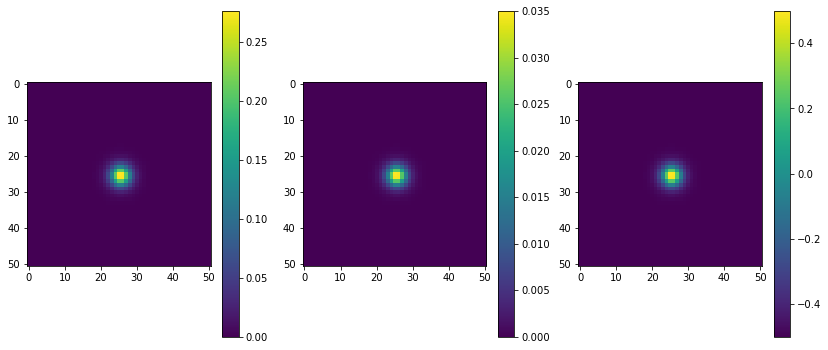

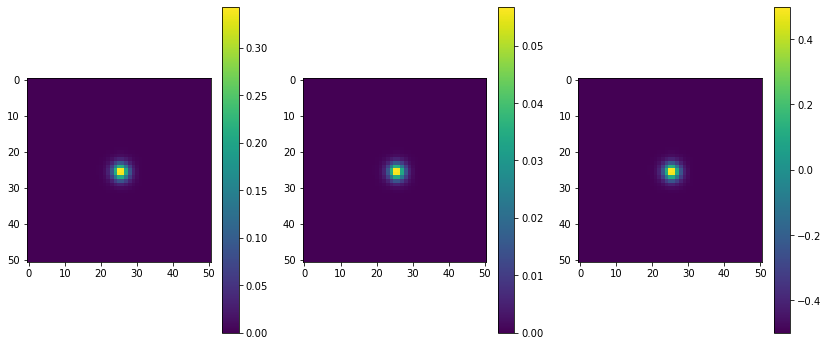

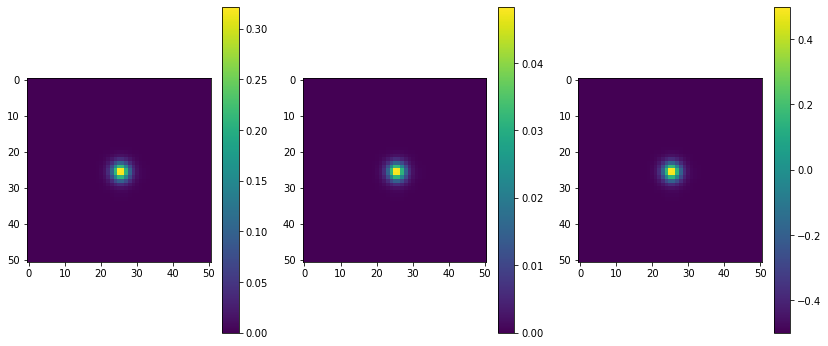

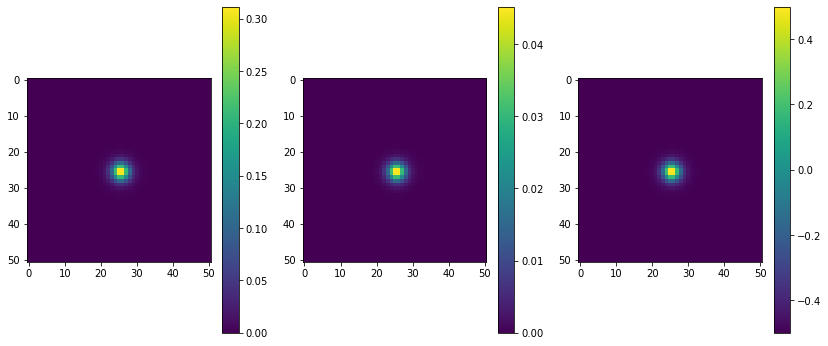

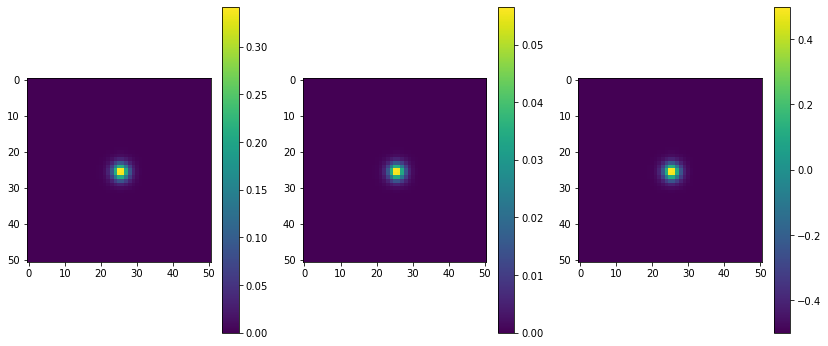

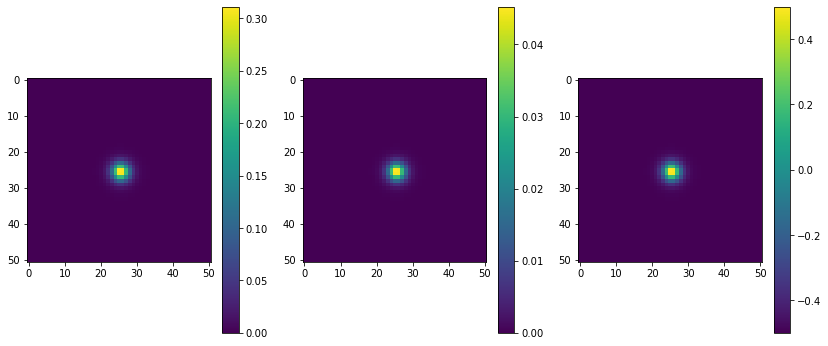

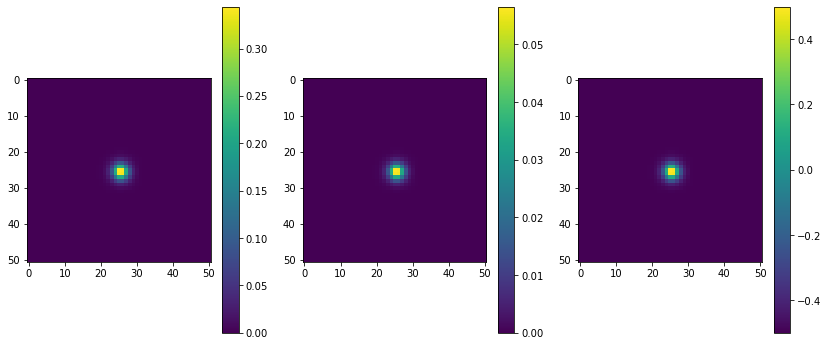

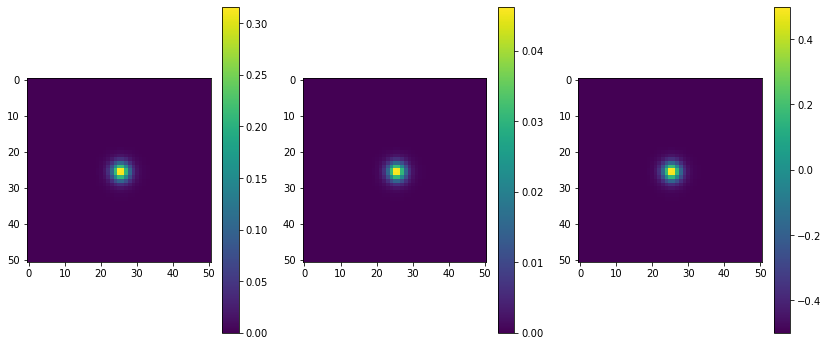

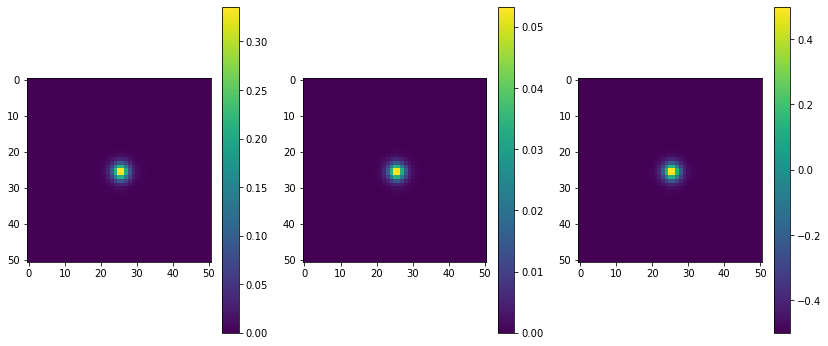

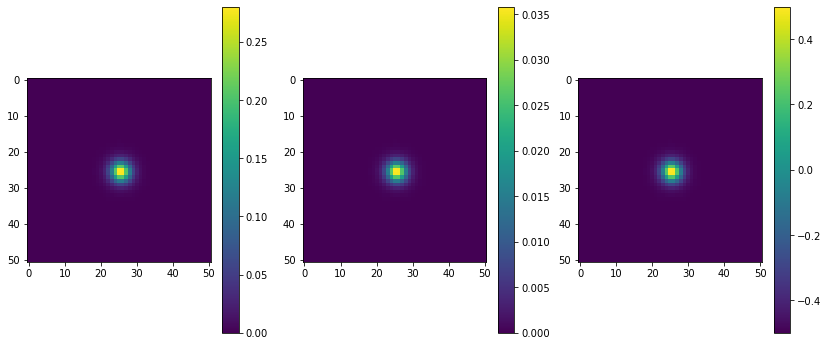

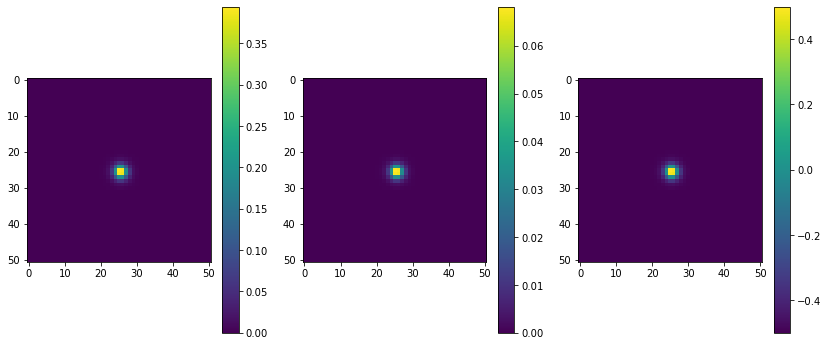

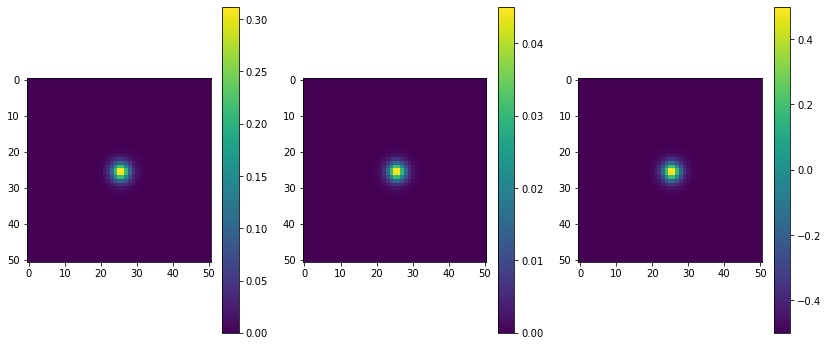

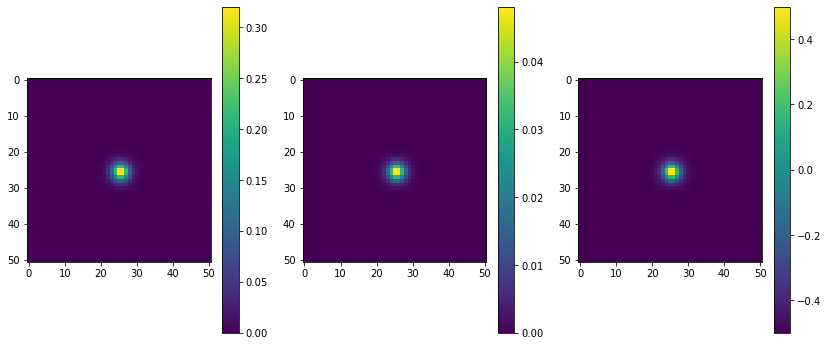

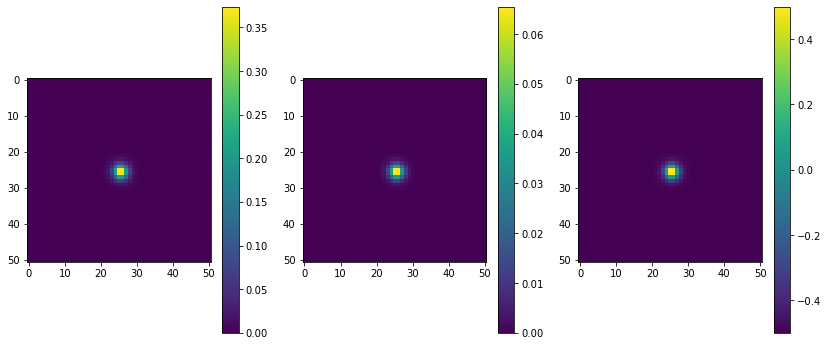

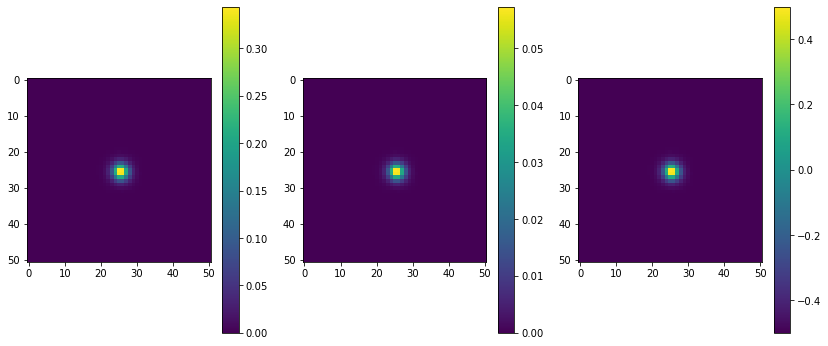

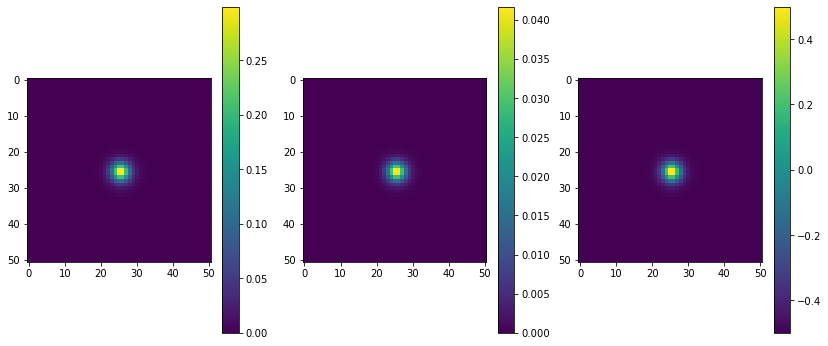

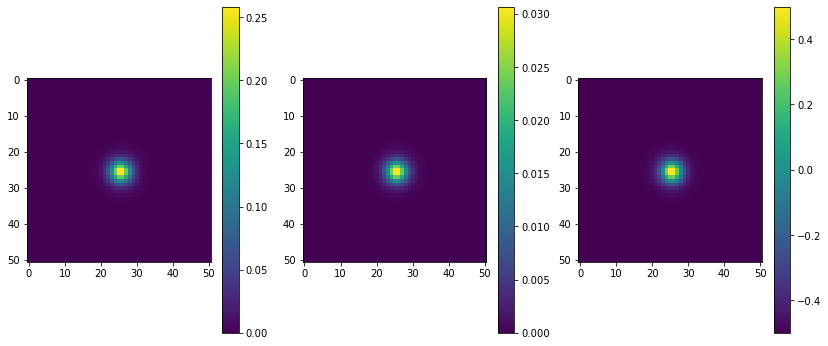

In [167]:

for it in range(20):
    figure(figsize=(14,6))
    subplot(131)
    imshow(norm_eigen[sum_mask][it,:,:]);colorbar()
    
    subplot(132)
    imshow(norm_1_eigen[sum_mask][it,:,:]);colorbar()
    
    subplot(133)
    imshow(scaled_eigen[sum_mask][it,:,:]);colorbar()
    
    show()


In [52]:

eigenPSFs = glob_eigen[1].data['VIGNETS_NOISELESS']

short_eigenPSF = eigenPSFs[0:5,:,:]

multiple = np.array([np.sum(short_eigenPSF[i,:,:])>0 for i in np.arange(len(short_eigenPSF))]) * 2. - 1.
short_eigenPSF *= multiple.reshape((-1, 1, 1))


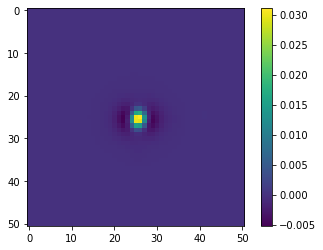

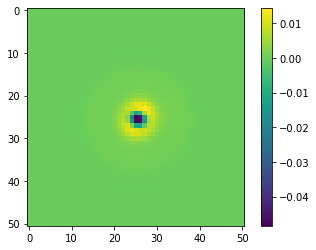

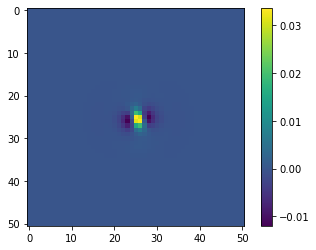

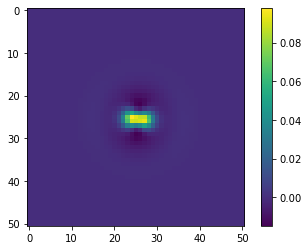

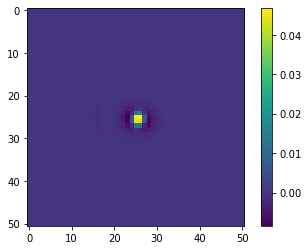

In [53]:

for it in range(5):
    figure()
    imshow(short_eigenPSF[it,:,:]);colorbar()
    show()


In [116]:


desired_SNR = 12
image_size = 51

sigma_noise = [np.sqrt((np.sum(img ** 2)) / (desired_SNR * image_size ** 2)) for img in short_eigenPSF]

# sigma_noise = [np.sqrt(np.sqrt((np.sum(img ** 2)) / (desired_SNR * image_size ** 2))) for img in short_eigenPSF]




In [117]:

noisy_eigen = np.array(
    [im + np.random.randn(image_size, image_size)*sig  
     for im,sig in zip(short_eigenPSF, sigma_noise)]
)


In [119]:
def mad(x):
    r"""Compute an estimation of the standard deviation 
    of a Gaussian distribution using the robust 
    MAD (Median Absolute Deviation) estimator."""
    return 1.4826*np.median(np.abs(x - np.median(x)))

def STD_estimator(image, window):    
    # Calculate noise std dev
    return mad(image[window])


def calculate_window(im_shape=(51, 51), win_rad=14):
    # Calculate window function for estimating the noise
    # We take the center of the image and a large radius to cut all the flux from the star
    window = np.ones(im_shape, dtype=bool)
    
    for coord_x in range(im_shape[0]):
        for coord_y in range(im_shape[1]):
            if np.sqrt((coord_x - im_shape[0]/2)**2 + (coord_y - im_shape[1]/2)**2) <= win_rad :
                window[coord_x, coord_y] = False

    return window



In [121]:

win = calculate_window()
calc_noise = [STD_estimator(im, win) for im in noisy_eigen]
calc_noise

[0.000438607445729464,
 0.0006963150974338771,
 0.0004744998974962517,
 0.0019295750451936776,
 0.0005695317947191366]

In [122]:
sigma_noise

[0.00043498077985988984,
 0.0006987642640532824,
 0.00045856256737356456,
 0.0019139162120078096,
 0.0005594421129795844]

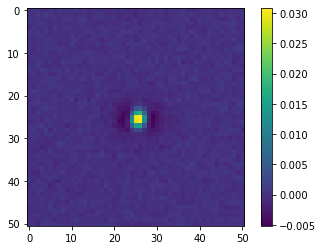

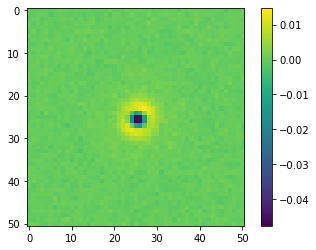

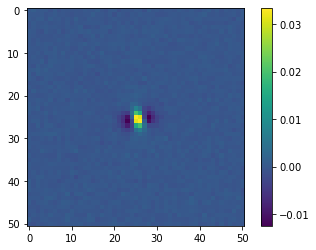

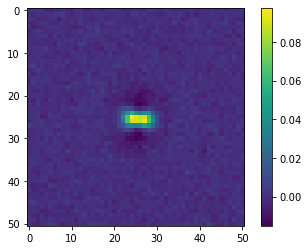

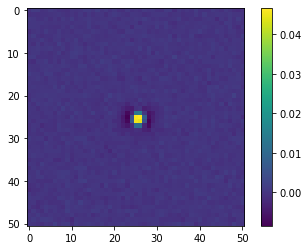

In [118]:

for it in range(5):
    figure()
    imshow(noisy_eigen[it,:,:]);colorbar()
    show()

### Test both models

In [63]:
def convert_and_pad_v2(image):
    r""" Convert images to tensorflow's tensor and add an extra 4th dimension."""
    return tf.expand_dims(tf.convert_to_tensor(image), axis=3)

def mad(x):
    r"""Compute an estimation of the standard deviation
    of a Gaussian distribution using the robust
    MAD (Median Absolute Deviation) estimator."""
    return 1.4826*np.median(np.abs(x - np.median(x)))

im_shape = (51,51)
noise_window = np.ones(im_shape, dtype=bool)
for coord_x in range(im_shape[0]):
    for coord_y in range(im_shape[1]):
        if np.sqrt((coord_x - 25.5)**2 + (coord_y - 25.5)**2) <= 13 :
            noise_window[coord_x, coord_y] = False

def noise_estimator(image):
    r"""Estimate the noise level of the image."""
    # Calculate noise std dev
    return mad(image[noise_window])

def crop_and_convert(image):
    r"""Convert to numpy array and remove the 4th dimension."""
    return image.numpy()[:,:,:,0]
    

In [61]:

# tf_noisy_eigen = convert_and_pad_v2(noisy_eigen)


In [62]:

image = noisy_eigen

noise = np.array([noise_estimator(image[_i,:,:]) for _i in np.arange(len(image))])
noise = tf.reshape(tf.convert_to_tensor(noise), [len(image), 1])



In [64]:
image = convert_and_pad_v2(image)

old_image = old_model.predict((image, noise))
new_image = new_model.predict((image, noise))

old_image = tf.math.multiply(multiple.reshape((-1, 1, 1, 1)), old_image)
new_image = tf.math.multiply(multiple.reshape((-1, 1, 1, 1)), new_image)



old_image = crop_and_convert(old_image)
new_image = crop_and_convert(new_image)


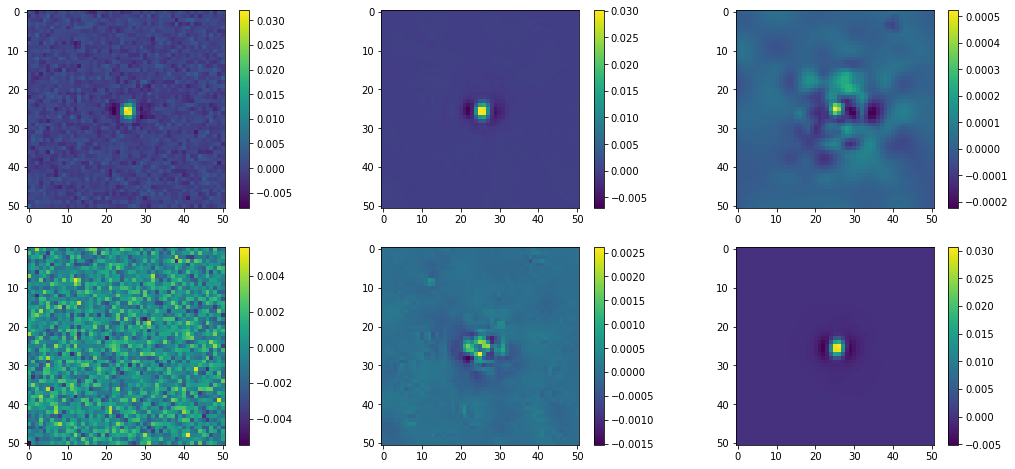

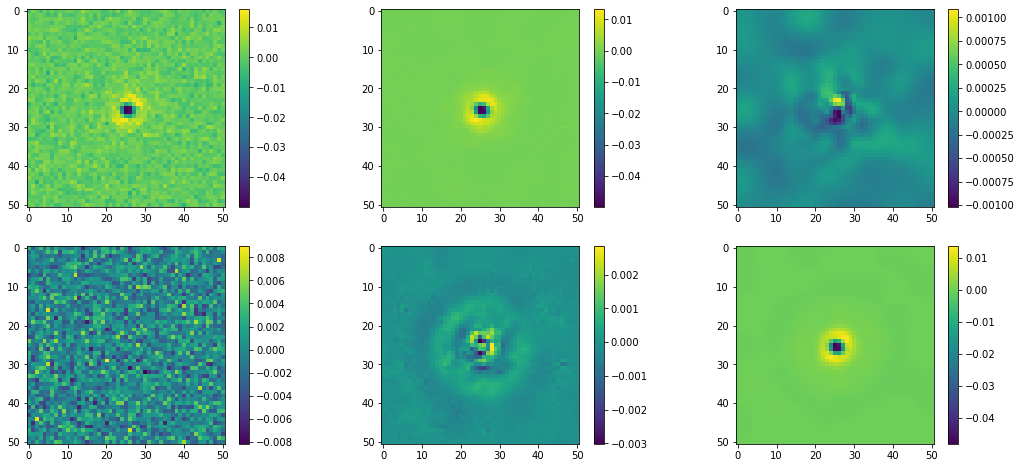

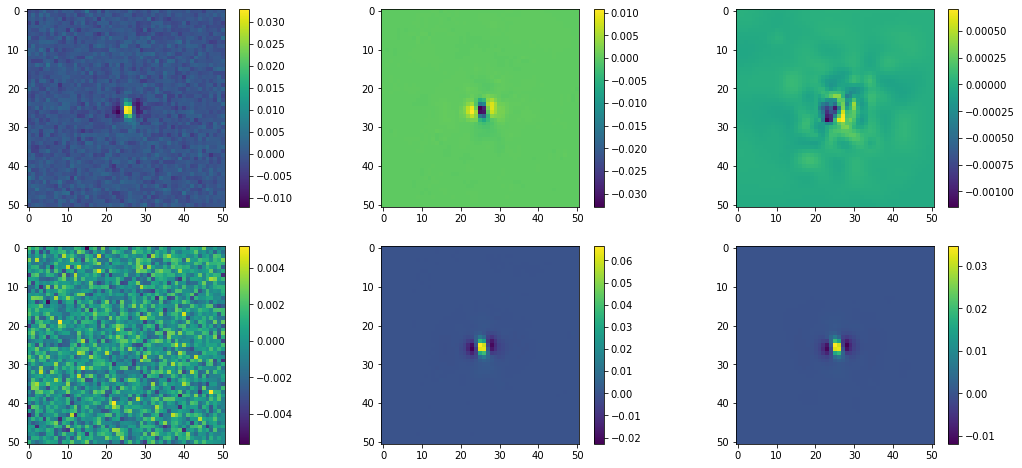

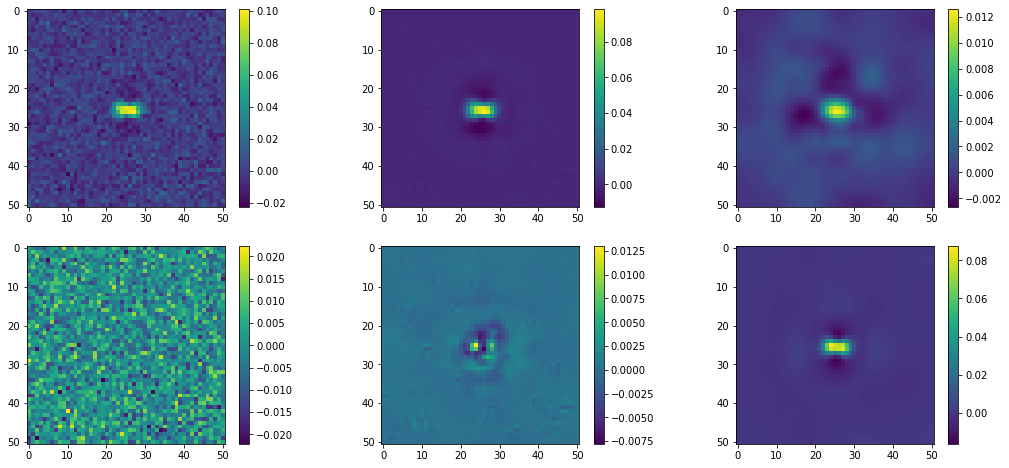

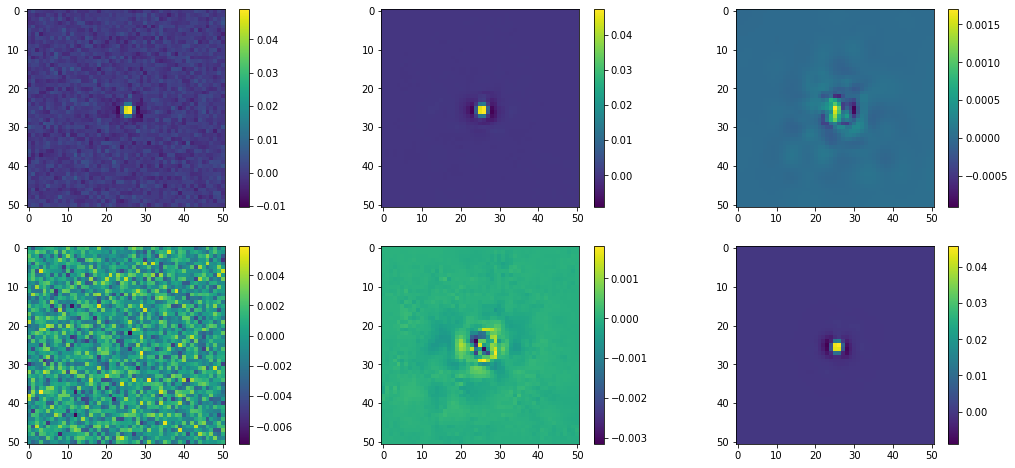

In [73]:


for it in range(5):
    figure(figsize=(18,8))
    subplot(231)
    imshow(noisy_eigen[it,:,:]);colorbar()
    
    subplot(232)
    imshow(old_image[it,:,:]);colorbar()
    
    subplot(233)
    imshow(new_image[it,:,:]);colorbar()
 
    subplot(234)
    imshow(short_eigenPSF[it,:,:] - noisy_eigen[it,:,:]);colorbar()
    
    subplot(235)
    imshow(short_eigenPSF[it,:,:] - old_image[it,:,:]);colorbar()
    
    subplot(236)
    imshow(short_eigenPSF[it,:,:] - new_image[it,:,:]);colorbar()
    
    
    show()


In [102]:

noisy_tensor = tf.expand_dims(tf.convert_to_tensor(noisy_eigen[0,:,:]), axis=0)
noisy_tensor.shape


TensorShape([1, 51, 51])

In [103]:

tf.norm(noisy_tensor)


<tf.Tensor: shape=(), dtype=float64, numpy=0.13142860950289237>

In [106]:

tf.reduce_sum(noisy_tensor**2)


<tf.Tensor: shape=(), dtype=float64, numpy=0.01727347939586377>

In [105]:

np.sqrt(np.sum(noisy_eigen[0,:,:]**2))


0.13142860950289234

In [143]:
def normalise(image):
    """ Normalise. 
    
    I in [a,b]
    Operations are:
    [0,b-a]
    [0, 1]
    tilde(I) in [-0.5, 0.5]
    """

    image -= tf.math.reduce_min(image)
    image /= tf.math.reduce_max(image)
    return image - 0.5


In [144]:

check_norm = normalise(noisy_tensor)


In [147]:
np.min(check_norm.numpy())

-0.5